In [1]:
##################### Import Libraries ############################
import pybamm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#################### Initiate Blank Model #########################
model = pybamm.BaseModel()
model.name = "Marinescu_2018"

In [3]:
################### Variables #####################################
S8 = pybamm.Variable("S8")
S4 = pybamm.Variable("S4")
S2 = pybamm.Variable("S2")
S  = pybamm.Variable("S")
Sp = pybamm.Variable("Sp")
Ss = pybamm.Variable("Ss")
V  = pybamm.Variable("V")

In [4]:
# Model Variables
model.variables = {"S8" : S8,
                   "S4" : S4,
                   "S2" : S2,
                   "S" : S,
                   "Sp" : Sp,
                   "Ss" : Ss,
                   "V" : V}

In [46]:
##################### Parameters #################################

# Set Parameters values normally

R = 8.3145
T = 298
F = 9.649*(10**4)
v = 0.0114

EH0 = 2.35
EL0 = 2.18

k_p    = 100
k_s    = 0 #0.0002 for charge
f_s    = 0.25
S_star = 0.0001
rho_s  = 2*(10**3)

Ms = 32
ne  = 4
ns  = 1
ns2 = 2
ns4 = 4
ns8 = 8
n4  = 4

ih0 = 1
il0 = 0.5
ar  = 0.960
m_s = 2.7
I   = 0

i_h_term_coef   = ns8*Ms*I*v*rho_s/(ne*F*k_p*(m_s**2))

i_coef   = ne*F/(2*R*T)
i_h_coef = -2*ih0*ar
i_l_coef = -2*il0*ar

E_H_coef = R*T/(4*F)
f_h      = (ns4**2)*Ms*v/ns8
f_l      = (ns**2)*ns2*Ms**2*(v**2)/ns4


In [47]:
########################## Given Initial Conditions ####################################
# Given values (dimensional)
S8_initial = 0.998*m_s
S4_initial = 0.001*m_s
S_initial  = S_star
Ss_initial = 0
I_initial  = 0

In [48]:
################# Nested Functions With Numpy ##################################

# Nernst Potentials

def E_H_np(S8,S4,EH0,E_H_coef,f_h):
    return EH0 + E_H_coef*np.log(f_h*S8/ (S4**2) )

def E_L_np(S,S2,S4,EL0,E_H_coef,f_l):
    return EL0 + E_H_coef*np.log(f_l*S4/ (S2*(S**2)) )

# Surface Overpotentials

def eta_H_np(V,S8,S4,EH0,E_H_coef,f_h):
    return V-E_H_np(S8,S4,EH0,E_H_coef,f_h)

def eta_L_np(V,S,S2,S4,EL0,E_H_coef,f_l):
    return V-E_L_np(S,S2,S4,EL0,E_H_coef,f_l,)

# Half-cell Currents

def i_H_np(V,S8,S4,EH0,E_H_coef,f_h,i_coef,i_h_coef):
    return i_h_coef*np.sinh(i_coef*eta_H_np(V,S8,S4,EH0,E_H_coef,f_h))

def i_L_np(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef):
    return i_l_coef*np.sinh(i_coef*eta_L_np(V,S,S2,S4,EL0,E_H_coef,f_l))

def algebraic_condition_func_np(V,S,S2,S4,S8,EL0,EH0,E_H_coef,f_l,f_h,i_coef,i_l_coef,i_h_coef,I):
    return i_H_np(V,S8,S4,EH0,E_H_coef,f_h,i_coef,i_h_coef) + i_L_np(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef) - I

In [49]:
########################## Derived Initial Conditions ##################################

import scipy as sp

V_initial = E_H_np(S8_initial,S4_initial,EH0,E_H_coef,f_h)

S2_initial = np.exp(n4*F*(EL0-V_initial)/(R*T))*(f_l*S4_initial/(S_initial**2))

Sp_initial = m_s - S8_initial - S4_initial - S2_initial - S_initial - Ss_initial

In [66]:
# Alternative initial conditions & current 
S8_initial = 2.694533668705614
S4_initial = 0.002766331283071
S2_initial = 0.000000000005594
Sp_initial = 0.002650000000843
Ss_initial = 0
S_initial  = 0.000050000004750
V_initial  = 2.418278144020148
I = 2

In [67]:
# Initial Conditions
model.initial_conditions = {S8 : pybamm.Scalar(S8_initial), S4 : pybamm.Scalar(S4_initial), S2 : pybamm.Scalar(S2_initial),S : pybamm.Scalar(S_initial),Sp : pybamm.Scalar(Sp_initial),Ss : pybamm.Scalar(Ss_initial), V : pybamm.Scalar(V_initial)}

In [68]:
################# Nested Functions With PyBaMM ##################################

# Nernst Potentials

def E_H(S8,S4,EH0,E_H_coef,f_h):
    return EH0 + E_H_coef*pybamm.log(f_h*S8/((S4**2)))

def E_L(S,S2,S4,EL0,E_H_coef,f_l):
    return EL0 + E_H_coef*pybamm.log(f_l*S4/(S2*(S**2)))

# Surface Overpotentials

def eta_H(V,S8,S4,EH0,E_H_coef,f_h):
    return V-E_H(S8,S4,EH0,E_H_coef,f_h)

def eta_L(V,S,S2,S4,EL0,E_H_coef,f_l):
    return V-E_L(S,S2,S4,EL0,E_H_coef,f_l,)

# Half-cell Currents

def i_H(V,S8,S4,EH0,E_H_coef,f_h,i_coef,i_h_coef):
    return i_h_coef*pybamm.sinh(i_coef*eta_H(V,S8,S4,EH0,E_H_coef,f_h))

def i_L(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef):
    return i_l_coef*pybamm.sinh(i_coef*eta_L(V,S,S2,S4,EL0,E_H_coef,f_l))

def algebraic_condition_func(V,S,S2,S4,S8,EL0,EH0,E_H_coef,f_l,f_h,i_coef,i_l_coef,i_h_coef,I):
    return i_H(V,S8,S4,EH0,E_H_coef,f_h,i_coef,i_h_coef) + i_L(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef) - I

In [69]:
################### Dynamic Equations ########################################
# ODEs
dS8dt = -(ns8*Ms*i_H(V,S8,S4,EH0,E_H_coef,f_h,i_coef,i_h_coef)/n4*F) - k_s*S8
dS4dt = (2*ns4*Ms*i_H(V,S8,S4,EH0,E_H_coef,f_h,i_coef,i_h_coef)/n4*F) + (1-(f_s*Ss/m_s))*k_s*S8 - (ns4*Ms*i_L(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef)/n4*F)
dS2dt = ns2*Ms*i_L(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef)/n4*F
dSdt  = (2*ns*Ms*i_L(V,S,S2,S4,EL0,E_H_coef,f_l,i_coef,i_l_coef)/n4*F) - (k_p*Sp*(S-S_star)/v*rho_s)
dSpdt = k_p*Sp*(S-S_star)/v*rho_s
dSsdt = k_s*S8

# Algebraic Condition
algebraic_condition = algebraic_condition_func(V,S,S2,S4,S8,EL0,EH0,E_H_coef,f_l,f_h,i_coef,i_l_coef,i_h_coef,I)

In [70]:
############# Model implementation ###############################################
model.rhs = {S8 : dS8dt, 
             S4 : dS4dt, 
             S2 : dS2dt, 
             S  : dSdt, 
             Sp : dSpdt, 
             Ss : dSsdt }
model.algebraic = {V : algebraic_condition}

In [71]:
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model);

In [72]:
# solver initiated
dae_solver = pybamm.CasadiSolver(mode="safe",atol=1e-6)
seconds = 0.1
dt = 1e-6
t = np.linspace(0, seconds, int(seconds/dt))
solution = dae_solver.solve(model, t)

CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2020-05-05 13:53:16 WARNING("F:daeF failed: Inf detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_fun

SolverError: .../casadi/interfaces/sundials/idas_interface.cpp:569: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.

In [56]:
# retrieve data
t_sol = solution.t
S8_sol = solution["S8"].data
S4_sol = solution["S4"].data
S2_sol = solution["S2"].data
S_sol  = solution["S"].data
Sp_sol = solution["Sp"].data
Ss_sol = solution["Ss"].data
V_sol  = solution["V"].data

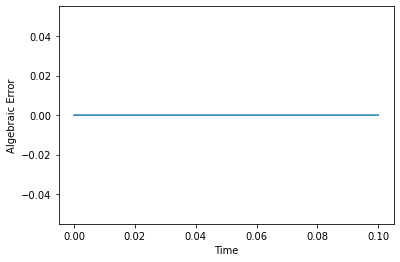

In [57]:
# check algebraic condition is satisfied
I_list = []

for i in range(len(V_sol)):
    I_list.append(algebraic_condition_func_np(V_sol[i],S_sol[i],S2_sol[i],S4_sol[i],S8_sol[i],EL0,EH0,E_H_coef,f_l,f_h,i_coef,i_l_coef,i_h_coef,I))
    
plt.plot(t_sol,I_list)
plt.xlabel('Time')
plt.ylabel('Algebraic Error');

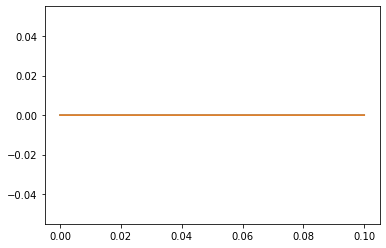

In [58]:
def numerical_deriv(x,t):
    n = len(x)
    dt = t[1]-t[0]
    return (x[1:n]-x[0:n-1])/dt

S8_der = numerical_deriv(S8_sol,t_sol)
n = len(S8_der)
plt.plot(t_sol[0:n],S8_der)
plt.plot(t_sol[0:n],-(ns8*Ms*i_H_np(V_sol[0:n],S8_sol[0:n],S4_sol[0:n],EH0,E_H_coef,f_h,i_coef,i_h_coef)/n4*F) - k_s*S8_sol[0:n])

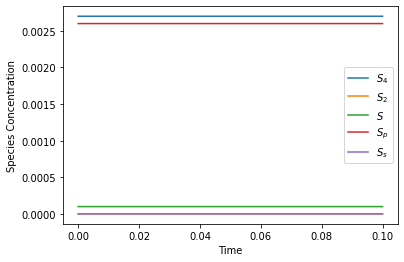

In [59]:
plt.plot(t_sol, S4_sol)
plt.plot(t_sol, S2_sol)
plt.plot(t_sol, S_sol)
plt.plot(t_sol, Sp_sol)
plt.plot(t_sol, Ss_sol)
plt.xlabel("Time")
plt.ylabel("Species Concentration")
plt.legend(['$S_4$','$S_2$','$S$','$S_p$','$S_s$'])

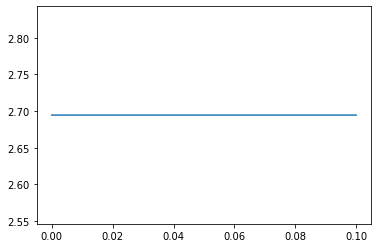

In [60]:
plt.plot(t_sol, S8_sol)

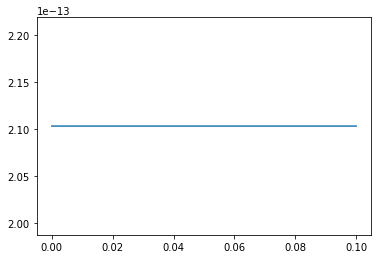

In [61]:
plt.plot(t_sol,S2_sol)

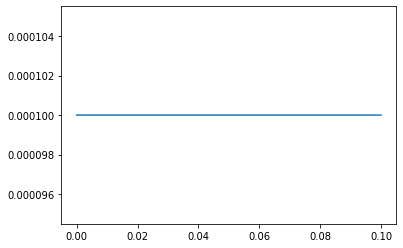

In [62]:
plt.plot(t_sol,S_sol)

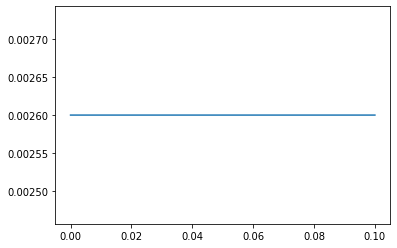

In [63]:
plt.plot(t_sol,Sp_sol)

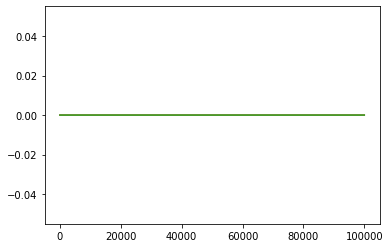

In [64]:
eh_list = []
el_list = []

for i in range(len(V_sol)):
    eh_list.append(E_H_np(S8_sol[i],S4_sol[i],EH0,E_H_coef,f_h))
    el_list.append(E_L_np(S_sol[i],S2_sol[i],S4_sol[i],EL0,E_H_coef,f_l))
    
plt.plot(eh_list-V_sol)
plt.plot(el_list-V_sol)
plt.plot(np.zeros(len(V_sol)))

Text(0, 0.5, 'Voltage')

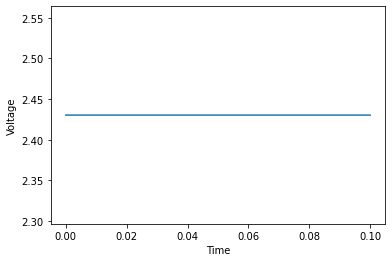

In [65]:
plt.plot(t_sol, V_sol)
plt.xlabel("Time")
plt.ylabel("Voltage")

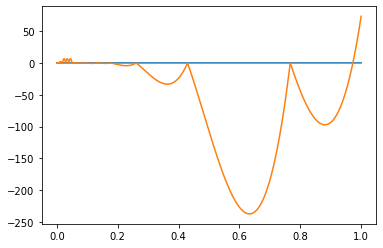

In [35]:
def numerical_deriv(x,t):
    n = len(x)
    dt = t[1]-t[0]
    return (x[1:n]-x[0:n-1])/dt

S8_der = numerical_deriv(S8_sol,t_sol)
n = len(S8_der)
plt.plot(t_sol[0:n],S8_der)
plt.plot(t_sol[0:n],-(ns8*Ms*i_H_np(V_sol[0:n],S8_sol[0:n],S4_sol[0:n],EH0,E_H_coef,f_h,i_coef,i_h_coef)/n4*F) - k_s*S8_sol[0:n])

In [ ]:
# Define Paremters for PyBaMM

param_dict = {  "R" : 8.3145,
                "T" : 298,
                "F" : 9.649*(10**4),
                "v" : 0.0114,

                "EH0" : 2.35,
                "EL0" : 2.195,

                "k_p"    : 100,
                "k_s"    : 0.0002,
                "f_s"    : 0.25,
                "S_star" : 0.0001,
                "rho_s"  : 2*(10**3),

                "Ms"  : 32,
                "ne"  : 4,
                "ns"  : 1,
                "ns2" : 2,
                "ns4" : 4,
                "ns8" : 8,
                "n4"  : 4,

                "ih0" : 10,
                "il0" : 5,
                "ar"  : 0.960,
                "m_s" : 2.7,
                "I"   : 0,

                "i_h_term_coef"   : ns8*Ms*I*v*rho_s/(ne*F*k_p*(m_s**2)),

                "i_coef"   : ne*F/(2*R*T),
                "i_h_coef" : -2*ih0*ar,
                "i_l_coef" : -2*il0*ar,

                "E_H_coef" : R*T/(4*F),
                "f_h"      : (ns4**2)*Ms*v/ns8,
                "f_l"      : (ns**2)*ns2*Ms**2*(v**2)/ns4}

parameter_values = pybamm.ParameterValues(param_dict)

# Define variables used as pybamm parameters 
R = pybamm.Parameter("R")
T = pybamm.Parameter("T")
F = pybamm.Parameter("F")
v = pybamm.Parameter("v")

EH0 = pybamm.Parameter("EH0")
EL0 = pybamm.Parameter("EL0")

k_p    = pybamm.Parameter("k_p")
k_s    = pybamm.Parameter("k_s")
f_s    = pybamm.Parameter("f_s")
S_star = pybamm.Parameter("S_star")
rho_s  = pybamm.Parameter("rho_s")

Ms  = pybamm.Parameter("Ms")
ne  = pybamm.Parameter("ne")
ns  = pybamm.Parameter("ns")
ns2 = pybamm.Parameter("ns2")
ns4 = pybamm.Parameter("ns4")
ns8 = pybamm.Parameter("ns8")
n4  = pybamm.Parameter("n4")

ih0 = pybamm.Parameter("ih0")
il0 = pybamm.Parameter("il0")
ar  = pybamm.Parameter("ar")
m_s = pybamm.Parameter("m_s")
I   = pybamm.Parameter("I") 

i_h_term_coef   = pybamm.Parameter("i_h_term_coef")

i_coef   = pybamm.Parameter("i_coef")
i_h_coef = pybamm.Parameter("i_h_coef")
i_l_coef = pybamm.Parameter("i_l_coef")

E_H_coef = pybamm.Parameter("E_H_coef")
f_h      = pybamm.Parameter("f_h")
f_l      = pybamm.Parameter("f_l")

model.param = parameter_values

